In [39]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
np.random.seed(5)

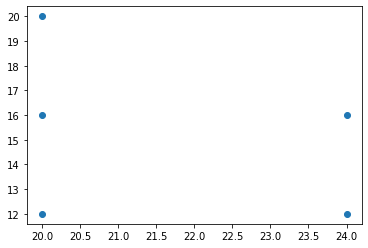

In [57]:
# assume a very simple double integrator dynamics, dx=Ax+Bu, x = [x,dx,y,dy]
dt = 0.2
A = np.array([[1, dt, 0, 0],
              [0, 1, 0, 0], 
              [0, 0, 1, dt], 
              [0, 0, 0, 1]])
B = np.array([[0, 0],
              [dt, 0],
              [0, 0],
              [0, dt]])
# assume some random initial position
num_agent = 5
m,n = B.shape
# px_init = np.random.rand(num_agent)*100
# py_init = np.random.rand(num_agent)*100
px_init = np.array([20, 20, 24, 24, 20]).T
py_init = np.array([20, 16, 16, 12, 12]).T
x_init = np.zeros((m,num_agent))
x_init[0] = px_init
x_init[2] = py_init
priority = np.arange(num_agent)
# np.random.shuffle(priority)
plt.scatter(px_init,py_init)
plt.show()

In [58]:
def Decentralized_CP(A,B,x_init,x_fin,Umax,Vmax,T,dt,R_col,x_nom,x_neigbs_p,collision_check):
    m, n = B.shape
    G = np.array([
        [1,0,0,0],
        [0,0,1,0]
    ])
    H = np.array([
        [0,1,0,0],
        [0,0,0,1]
    ])
    x = cp.Variable((T,m))
    u = cp.Variable((T-1,n))
    objective = cp.Minimize(cp.sum(cp.norm(u,axis=1))*dt)
    constraints = [ x[0] == x_init, x[T-1] == x_fin ]
    for k in range(T-1):
        constraints.append( x[k+1] == A@x[k] + B@u[k] )
        constraints.append( cp.norm(u[k]) <= Umax )
        constraints.append( cp.norm(H@x[k+1]) <= Vmax)
        if len(x_neigbs_p) != 0 and collision_check:
            for x_neigb in x_neigbs_p:
                x_neigb = x_neigb.T
#                 print(R_col*np.linalg.norm(x_nom[k]-x_neigb[k]))
#                 print(G@(x_nom[k]-x_neigb[k]))
                constraints.append( (x_nom[k]-x_neigb[k]).T@G.T@G@(x[k]-x_neigb[k]) >= R_col*cp.norm(G@(x_nom[k]-x_neigb[k])) )
    
    prob = cp.Problem(objective,constraints)
    prob.solve()
    return x.value, u.value, prob.value, prob.status
    
def compute_laplacian(x,R_com):
    _, num_agent = x.shape
    L = np.zeros((num_agent,num_agent))
    px, py = x[0].reshape(1,-1), x[2].reshape(1,-1)
    dist = np.sqrt((px-px.T)**2+(py-py.T)**2)
    L[dist <= R_com] = 1
    L -= np.diag(np.ones((num_agent)))
    return L


def communicate_traj(L,priority,K,x_nom):
    communication = {}
    for agent_i in K:
        communication[agent_i] = []
        for agent_j in K:
            if L[agent_i,agent_j] == 1 and priority[agent_i] < priority[agent_j]: 
                communication[agent_i].append(x_nom[agent_j,:,:])
    return communication

def check_collision(L,prioprity,x_i,x_nom,agent_i,K,R_col):
    is_collision = []
    for agent_j in K:
            if L[agent_i,agent_j] == 1 and priority[agent_i] < priority[agent_j]:
                px_i = x_i[0]
                py_i = x_i[2]
                px_j = x_nom[agent_j][0]
                py_j = x_nom[agent_j][2]
                is_collision.append(np.linalg.norm((px_i-px_j,py_i-py_j),axis=0))
    return np.all(np.array(is_collision) > R_col)

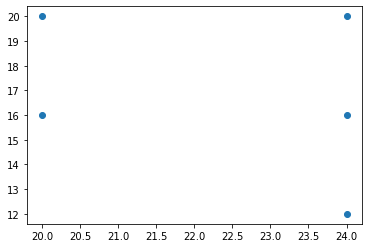

In [59]:
## Temporary
# p_fin = np.loadtxt('S1.txt',delimiter='\t')
T = 30
px_fin = np.array([24, 20, 20, 24, 24])
py_fin = np.array([20, 20, 16, 16, 12])
# px_fin = np.random.rand(num_agent)*100
# py_fin = np.random.rand(num_agent)*100
x_fin = np.zeros((m,num_agent))
x_fin[0] = px_fin
x_fin[2] = py_fin
Umax = 5
R_col = 0.01
R_com = 10
Vmax = 10
plt.scatter(px_fin,py_fin)
plt.show()

In [55]:
def Swarm_SCP(A,B,num_agent,x_init,x_fin,Umax,Vmax,T,dt,R_col,R_com,priority,collision_check):
    m,n = B.shape
    eps = 1e-3
    K = np.arange(num_agent).tolist()
    K_const = np.copy(K)
    x_nom = np.zeros((num_agent,m,T))
    u_nom = np.zeros((num_agent,n,T-1))
    all_cost = np.zeros((num_agent,T-1))
    x_neigbs_p = []
    for agent in K:
        x_agent, u_agent, _, _ = Decentralized_CP(A,B,x_init[:,agent],x_fin[:,agent],Umax,Vmax,T,dt,R_col,
                                               x_nom[agent].T,x_neigbs_p,collision_check)
        x_nom[agent] = x_agent.T

    L = compute_laplacian(x_init,R_com)
    neigbs_p_all = communicate_traj(L,priority,K,x_nom)
    w = 0
    while len(K) != 0:
        print(w)
        for agent in K:
            x_nom_prev = np.copy(x_nom)
            x_neigbs_p = neigbs_p_all[agent]
            x_agent, u_agent, cost, status = Decentralized_CP(A,B,x_init[:,agent],x_fin[:,agent],Umax,Vmax,T,dt,
                                                      R_col,x_nom[agent].T,x_neigbs_p,collision_check)
            print(status)
            if status == 'infeasible':
                return x_nom, u_nom, all_cost
            x_nom[agent] = x_agent.T
            u_nom[agent] = u_agent.T
            all_cost[agent] = cost
    #     L = compute_laplacian(x_init,R_com)
        neigbs_p_all = communicate_traj(L,priority,K_const,x_nom)
        K_list = np.copy(K)
        K_list = K_list.tolist()
        for agent in K_const:
            if np.linalg.norm(x_nom[agent]-x_nom_prev[agent],np.inf) < eps and \
            check_collision(L,priority,x_nom[agent],x_nom,agent,K_const,R_col):
                K_list.remove(agent)
        w += 1
        K = np.copy(K_list)
        K = K.tolist()
    return x_nom, u_nom, all_cost

0
optimal
optimal
optimal
optimal
optimal


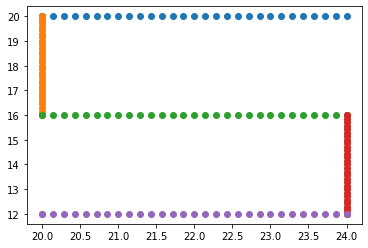

In [25]:
x_nom,u_nom,all_cost = Swarm_SCP(A,B,num_agent,x_init,x_fin,Umax,Vmax,T,dt,R_col,R_com,priority,True)
# for i in range(T):
#     plt.scatter(x_nom[:,0,i],x_nom[:,2,i])
    
for i in range(num_agent):
    plt.scatter(x_nom[i,0,:],x_nom[i,2,:])

In [46]:
def downwash(dx,dy,sigma):
    x_dist = -1/(sigma*np.sqrt(2*np.pi))*np.exp(-(dx/sigma)**2/2)
    y_dist = max(0, 6.5-dy/(1*sigma))
    return x_dist*y_dist

In [47]:
k0 = 0
x = x_init
all_x = [x]
all_u = []
eps = 1e-3
sigma = 0.8
num_iter = 0
while True:
    x_nom, u_nom, all_cost = Swarm_SCP(A, B, num_agent, x, x_fin, Umax, Vmax, T, dt, R_col, R_com, priority, True)
#     downwash_effct = downwash(x[0, 0] - x[0, 1], np.abs(x[2, 0] - x[2, 1]), sigma)
#     disturbance = np.zeros((num_agent, 2))
#     disturbance[1, 0] = downwash_effct
#     compensator = np.zeros_like(disturbance)
#     compensator[1,0] = nnet.predict(np.array([x[0, 0] - x[0, 1], np.abs(x[2, 0] - x[2, 1])]).reshape(1,2))
    pos_diff = compute_all_pos_diff(x)
#     dx, dy = compute_pos_diff_matrix(x[0,:],x[2,:])
#     W = compute_dist_comp_matrix(dy)
#     disturbance = compute_dist_comp_mat(W,dx,dy).T
#     dist = np.concatenate((np.zeros((1,5)),disturbance),axis=0)
    
    print(compute_dist_comp_matrix(x,pos_diff,sigma))
    x = A@x+B@(u_nom[:,:,0].T + 2*compute_dist_comp_matrix(x,pos_diff,sigma))
#     x = A@x+B@(u_nom[:,:,0].T + 2*dist)
    all_x.append(x)
    all_u.append(u_nom[:,:,0].T)
    if np.all(x-x_fin <= eps): break
    T -= 1
    if T == 1: raise Exception("Planning horizon not long enough")

0
optimal
optimal
optimal
optimal
optimal
[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -1.49624848  0.06953484 -1.46710992 -0.77087831]]
0
optimal
optimal
optimal
optimal
optimal
[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -1.49624848  0.06953484 -1.46710992 -0.77087831]]
0
optimal
optimal
optimal
optimal
optimal
[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -1.50020635  0.35318655 -1.46361351 -0.3862451 ]]
0
optimal
optimal
optimal
optimal
optimal
[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -1.4589057   0.34171063 -1.41544867 -0.22562692]]
0
optimal
optimal
optimal
optimal
optimal
[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -1.37638116  0.32836783 -1.30348647 -0.07943782]]
0
optimal
optimal
optimal
optimal
optimal
[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -1.26429713  0.30813968 -1.1705054  

AttributeError: 'NoneType' object has no attribute 'T'

(28, 4, 5)


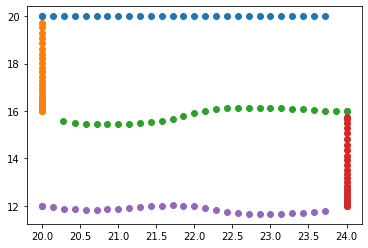

In [48]:
x = np.array(all_x)
print(x.shape)
for i in range(num_agent):
    plt.scatter(x[:,0,i],x[:,2,i])

In [ ]:
np.savetxt('mpc_dist.txt',x.reshape(28,-1),delimiter='\t')

In [ ]:
k0 = 0
x = x_init
all_x = [x]
all_u = []
eps = 1e-3
sigma = 0.8
K = np.zeros((2,4))
K[1,3] = 1
while True:
    downwash_effct = downwash(x[0, 0] - x[0, 1], np.abs(x[2, 0] - x[2, 1]), sigma)
#     print(x[0, 0] - x[0, 1],np.abs(x[2, 0] - x[2, 1]))
    disturbance = np.zeros((num_agent, 2))
    disturbance[1, 0] = downwash_effct
    u_nom = np.array([[2, 0],[0, 0]])
    print(downwash_effct,2.935402561181967**2*compensator[1,0])
    x = A@x+B@(u_nom.T + 2*disturbance)
    all_x.append(x)
    if x[0,0] >= 30: break

In [ ]:
x = np.array(all_x)
print(x.shape)
for i in range(num_agent):
    plt.scatter(x[:,0,i],x[:,2,i])
print(x[-1])
plt.ylim([19,24])

In [ ]:
np.savetxt('swap_nc.txt',x.reshape(18,-1),delimiter='\t')

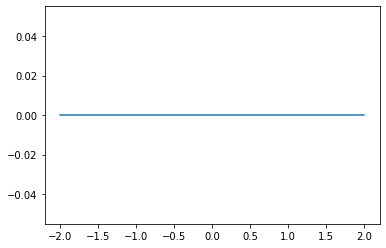

In [74]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D,MaxPool2D,Dropout,Flatten
from keras.callbacks import History
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.initializers import glorot_uniform
import os
from matplotlib import pyplot as plt

nnet = load_model('my_model_2.h5')

N = 1000
dx = np.linspace(-2, 2, N).reshape([-1, 1])
dy = (np.ones(N)*5).reshape([-1, 1])
data_in = np.concatenate((dx, dy), axis = 1)
all_x = []
for x in dx:
    all_x.append(downwash(x,dy[0],0.8))

data_out = np.array(all_x)-nnet.predict(data_in)*2.935402561181967**2
plt.plot(dx, data_out)



In [60]:
def compute_all_pos_diff(x):
    m, num_agent = x.shape
    pos_diff = []
    for i in range(num_agent):
        for j in range(num_agent):
            if j < i:
                pos_diff.append((x[0,i]-x[0,j],np.abs(x[2,i]-x[2,j])))
                
                
    return pos_diff

# x = np.random.randint(4,size=(4,5))
# compute_all_pos_diff(x)

In [64]:
def compute_dist_comp_matrix(pos_diff):
    num_agent = 5
    sigma = 0.8
    dist_comp_matrix = np.zeros((2,5))
    counter = 0
    for i in range(1,num_agent):
        disturbance = 0
        compensation = 0
        for k in range(i):
            disturbance += downwash(pos_diff[counter][0],pos_diff[counter][1],sigma)
            compensation += nnet.predict(np.array(pos_diff[counter]).reshape(1,2))
            counter += 1
        dist_comp_matrix[1,i] = disturbance - 2.935402561181967**2*compensation
    return dist_comp_matrix


x = x_init
print(compute_all_pos_diff(x))
print(compute_dist_comp_matrix(compute_all_pos_diff(x)))

# def compute_all_pos_diff(x):
#     m, num_agent = x.shape
#     pos_diff_dict = {}
#     for i in range(num_agent):
#         pos_diff_dict[i] = []
#         for j in range(num_agent):
#             if x[2, i] - x[2, j] < 0:
#                 pos_diff_dict[i].append((x[0, i] - x[0, j], np.abs(x[2, i] - x[2, j])))
#     return pos_diff_dict

# def compute_dist_comp_matrix(x, dict_pos_diff, sigma):
#     m, num_agent = x.shape
#     dist_matrix = np.zeros((2, num_agent))
#     for agent in range(num_agent):
#         for i in range(len(dict_pos_diff[agent])):
#             downwash_effect = downwash(dict_pos_diff[agent][i][0], dict_pos_diff[agent][i][1], sigma)
#             dist_matrix[1, agent] += downwash_effect
#             compensation = nnet.predict(np.array([dict_pos_diff[agent][i][0], dict_pos_diff[agent][i][1]]).reshape(1,2))
#             dist_matrix[1, agent] -= 2.935402561181967**2*compensation
#     return dist_matrix

[(0.0, 4.0), (4.0, 4.0), (4.0, 0.0), (4.0, 8.0), (4.0, 4.0), (0.0, 4.0), (0.0, 8.0), (0.0, 4.0), (-4.0, 4.0), (-4.0, 0.0)]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.14874744e-04 -3.61796319e-01 -2.89291143e-02
  -9.86158729e-01]]


In [ ]:
# def compute_dist_comp_matrix(pos_diff_y):
#     num_agents = 5
#     W = np.zeros((num_agents, num_agents))
#     for ii in range(num_agents):
#         for jj in range(num_agents):
#             if pos_diff_y[ii, jj] > 0:
#                 W[ii, jj] = 1
#             else:
#                 W[ii, jj] = 0
#     return W


# def compute_pos_diff_matrix(x, y):
#     num_agents = 5
#     del_x = np.zeros((num_agents, num_agents))
#     del_y = np.zeros((num_agents, num_agents))
#     for ii in range(num_agents):
#         for jj in range(num_agents):
#             del_x[ii, jj] = x[jj] - x[ii]
#             del_y[ii, jj] = y[jj] - y[ii]
            
#     return del_x, del_y


# def compute_dist_comp_mat(W, dx, dy):
#     num_agents = 5
#     dist_comp_mat = np.zeros((num_agents, num_agents))
#     for ii in range(num_agents):
#         for jj in range(num_agents):
#             dist = downwash(dx[ii, jj], dy[ii, jj], 0.8)
#             comp = nnet.predict(np.array([dx[ii, jj], dy[ii, jj]]).reshape(1,2))
#             dist_comp_mat[ii, jj] = W[ii, jj]*(dist)
    
#     return dist_comp_mat.sum(axis=1).reshape(-1,1)

# def compute_tot_dist_comp(M):
#     return M.sum(axis=1).reshape(-1,1)